In [2]:
from pathlib import Path
import pandas as pd
pd.set_option('display.max_colwidth', 20)   # JSON columns make things look weird in notebook without this
pd.options.mode.copy_on_write = True        # TESTING THIS...

In [3]:
# eval_folder = Path.home()/'evals/phase4_heads.eval.nginx'
# eval_folder = Path.home()/'evals/phase5.eval'
eval_folder = Path.home()/'evals/nginx.conf30'

In [4]:
dragon_results_folder = eval_folder/'dragon'
dryder_results_folder = eval_folder/'dragon_ryder'

ryder_folder = list(dryder_results_folder.glob('*.dragon-ryder'))[0]
ryder_folder.name
ryder_folder.with_suffix('.aligned.csv').exists()

# dragon-ryder model name
model_name = ryder_folder.with_suffix('').name

list(ryder_folder.iterdir())

pred_vars = pd.read_csv(ryder_folder/'predictions.csv')
hc_vars = pd.read_csv(ryder_folder/'high_conf_vars.csv')
hc_vars

,BinaryId,FunctionStart,Signature,Vartype,Name,Location,Pred,PredJson,NumRefs,NumOtherVars,Influence,Confidence,Retyped,Gen
0,0,1155913,35,p,param_1,LocType=register...,int32,"{""kind"": ""Builti...",1,2,4,0.795215,True,1
1,0,1155955,"19,39",l,sVar1,LocType=register...,uint64,"{""kind"": ""Builti...",2,1,2,0.993495,True,1
2,0,1155955,"19,39",p,param_1,LocType=register...,char*,"{""kind"": ""Pointe...",2,1,3,0.894065,True,1
3,0,1156002,"19,39",l,sVar1,LocType=register...,uint64,"{""kind"": ""Builti...",2,1,2,0.993495,True,1
4,0,1156002,"19,39",p,param_1,LocType=register...,char*,"{""kind"": ""Pointe...",2,1,3,0.894065,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12551,0,2085888,15,p,param_2,LocType=register...,STRUCT*,"{""kind"": ""Pointe...",1,1,2,0.999037,True,1
12552,0,2085920,20,p,param_1,LocType=register...,int32,"{""kind"": ""Builti...",1,3,3,0.796188,True,1
12553,0,2085920,20,p,param_2,LocType=register...,char*,"{""kind"": ""Pointe...",1,3,3,0.585055,True,1
12554,0,2085920,20,p,param_3,LocType=register...,STRUCT*,"{""kind"": ""Pointe...",1,3,3,0.848441,True,1


In [5]:
aligned_vars = pd.read_csv(ryder_folder.with_suffix('.aligned.csv'))
#aligned_vars

In [6]:
from datatype_recovery.eval_dataset import PandasEvalMetrics
from rich.console import Console
console = Console()

print(f'Mean confidence for high-confidence vars: {hc_vars.Confidence.describe()["mean"]*100:.2f}%')

percent_retyped = aligned_vars.Retyped.sum()/len(aligned_vars)*100
print(f'{percent_retyped:.2f}% of predicted vars were successfully retyped in Ghidra')

metrics = PandasEvalMetrics(aligned_vars, truth_col='TypeSeq', pred_col='PredSeq')

console.rule()
print(f'Overall accuracy: {metrics.accuracy*100:.2f}%')

Mean confidence for high-confidence vars: 66.38%
99.52% of predicted vars were successfully retyped in Ghidra


───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Overall accuracy: 67.76%


In [7]:
gb = aligned_vars.groupby('Gen')
acc_by_gen = pd.DataFrame({
        'Accuracy': gb.apply(lambda x: PandasEvalMetrics(x, 'TypeSeq','PredSeq').accuracy*100),
        'Size': gb.apply(lambda x: len(x)),
        'Percent': gb.apply(lambda x: len(x))/len(aligned_vars)*100,
        'Retyped': gb.apply(lambda x: x.Retyped.sum()),
        'Retyped_Percent': gb.apply(lambda x: x.Retyped.sum()/len(x))*100,
    }
)
acc_by_gen

,Accuracy,Size,Percent,Retyped,Retyped_Percent
Gen,,,,,
1,83.518825,4223,63.379859,4197,99.384324
2,40.491803,2440,36.620141,2434,99.754098


[Text(0, 0, '4223'), Text(0, 0, '2440')]

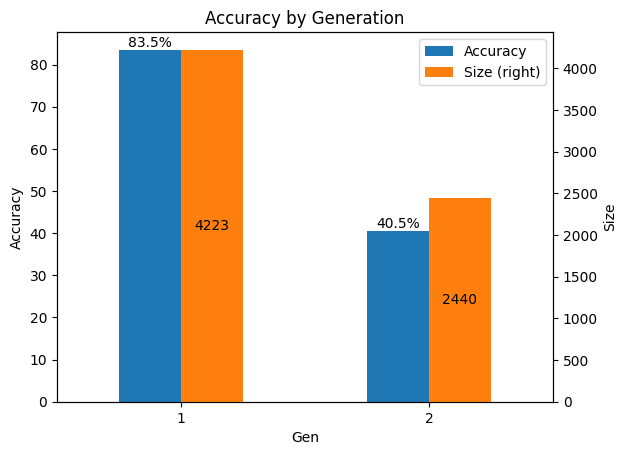

In [8]:
ax = acc_by_gen.plot(
    kind='bar', y=['Accuracy','Size'], secondary_y='Size', title='Accuracy by Generation', rot=0,
)
ax.set_ylabel('Accuracy')
ax.right_ax.set_ylabel('Size')
ax.bar_label(ax.containers[0], fmt='{:.1f}%')
ax.right_ax.bar_label(ax.right_ax.containers[0], label_type='center')

In [9]:
print(f'Of {len(pred_vars):,} predicted vars, only {len(aligned_vars):,} aligned with debug')

Of 25,847 predicted vars, only 6,663 aligned with debug
